In [220]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import unicodedata
from datetime import datetime

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import re

from collections import Counter
%matplotlib inline

In [221]:
raw_data = pd.read_csv('winemag-data-130k-v2.csv')
raw_data.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [222]:
# All we'll need are the country, description and variety. There is one data point without a variety, so let's drop it.
wine_data = raw_data[['description', 'variety']].dropna()

# The word description will come up in our data, so we need to change the name of the column for clarity.
wine_data = wine_data.rename(columns = {'description': 'description_text'})

# Make all of the varieties lower case so that Pinot Noir and pinot noir are recognized as the same
wine_data['variety'] = wine_data['variety'].str.lower()

wine_data.head(10)

,description_text,variety
0,"Aromas include tropical fruit, broom, brimston...",white blend
1,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,"Much like the regular bottling from 2012, this...",pinot noir
5,Blackberry and raspberry aromas show a typical...,tempranillo-merlot
6,"Here's a bright, informal red that opens with ...",frappato
7,This dry and restrained wine offers spice in p...,gewürztraminer
8,Savory dried thyme notes accent sunnier flavor...,gewürztraminer
9,This has great depth of flavor with its fresh ...,pinot gris


In [223]:
# Get rid of the special characters like the umlaut on the u in gewurztraminer
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

wine_data['variety'] = wine_data['variety'].apply(remove_accents)
wine_data['decription_text'] = wine_data['description_text'].apply(remove_accents)
   
wine_data.head(10)


,description_text,variety,decription_text
0,"Aromas include tropical fruit, broom, brimston...",white blend,"Aromas include tropical fruit, broom, brimston..."
1,"This is ripe and fruity, a wine that is smooth...",portuguese red,"This is ripe and fruity, a wine that is smooth..."
2,"Tart and snappy, the flavors of lime flesh and...",pinot gris,"Tart and snappy, the flavors of lime flesh and..."
3,"Pineapple rind, lemon pith and orange blossom ...",riesling,"Pineapple rind, lemon pith and orange blossom ..."
4,"Much like the regular bottling from 2012, this...",pinot noir,"Much like the regular bottling from 2012, this..."
5,Blackberry and raspberry aromas show a typical...,tempranillo-merlot,Blackberry and raspberry aromas show a typical...
6,"Here's a bright, informal red that opens with ...",frappato,"Here's a bright, informal red that opens with ..."
7,This dry and restrained wine offers spice in p...,gewurztraminer,This dry and restrained wine offers spice in p...
8,Savory dried thyme notes accent sunnier flavor...,gewurztraminer,Savory dried thyme notes accent sunnier flavor...
9,This has great depth of flavor with its fresh ...,pinot gris,This has great depth of flavor with its fresh ...


In [224]:
print('The original data set contains this many rows: {}'.format(len(wine_data)))
# Replace german names with English names for wines
wine_data['variety'] = wine_data['variety'].replace(['weissburgunder'], 'chardonnay')
wine_data['variety'] = wine_data['variety'].replace(['spatburgunder'], 'pinot noir')
wine_data['variety'] = wine_data['variety'].replace(['grauburgunder'], 'pinot gris')

# Replace the Spanish garnacha with the french grenache 
wine_data['variety'] = wine_data['variety'].replace(['garnacha'], 'grenache')

# Replace the Italian pinot nero with the french pinot noir
wine_data['variety'] = wine_data['variety'].replace(['pinot nero'], 'pinot noir')

# Replace the Portugues alvarinho with the spanish albarino
wine_data['variety'] = wine_data['variety'].replace(['alvarinho'], 'albarino')


# Let's get rid of generic blends
print('There are this many varieties that contain the word blend')
print(len(wine_data[wine_data.variety.str.contains('blend') == True]))
wine_data = wine_data[wine_data.variety.str.contains('blend') == False]

# Drop instances of rose because those can be made from a mulititude of varieties
print('There are this many roses in the data set')
print(len(wine_data[wine_data.variety.str.contains('rose') == True]))
wine_data = wine_data[wine_data.variety.str.contains('rose') == False]


# See how many varieties have a relatively insignificant number of instances and remove them
# This should improve the performance of our model by decreasing the number of possible outcomes without losing utility
print('There are this many wines in the rarer varieties')
print(sum(wine_data['variety'].value_counts()[wine_data['variety'].value_counts()<100]))

variety_counts = wine_data['variety'].value_counts().rename('variety_counts')

wine_data = wine_data.merge(variety_counts.to_frame(),
                                left_on='variety', right_index=True)

wine_data = wine_data[wine_data['variety_counts'] > 100]
wine_data = wine_data.drop(['variety_counts'], axis=1)

print('After cleaning, we now have this many rows of data: {}'.format(len(wine_data)))

The original data set contains this many rows: 129970
There are this many varieties that contain the word blend
25730
There are this many roses in the data set
3818
There are this many wines in the rarer varieties
6995
After cleaning, we now have this many rows of data: 93227


In [225]:
wine_data.head(10)

,description_text,variety,decription_text
1,"This is ripe and fruity, a wine that is smooth...",portuguese red,"This is ripe and fruity, a wine that is smooth..."
157,"From an estate in the south of the Alentejo, t...",portuguese red,"From an estate in the south of the Alentejo, t..."
203,A year in wood and 30 months in bottle before ...,portuguese red,A year in wood and 30 months in bottle before ...
217,Wood aging gives this ripe blend of Baga and T...,portuguese red,Wood aging gives this ripe blend of Baga and T...
473,"A powerful wine, richly structured and full of...",portuguese red,"A powerful wine, richly structured and full of..."
642,This is a new wine from the hands of master wi...,portuguese red,This is a new wine from the hands of master wi...
646,As its name suggests this is a selection of ba...,portuguese red,As its name suggests this is a selection of ba...
647,"This is an impressive, powerful wine. It speak...",portuguese red,"This is an impressive, powerful wine. It speak..."
773,"Powerful and concentrated, this is just at its...",portuguese red,"Powerful and concentrated, this is just at its..."
784,"This mature wine has a soft, smooth character ...",portuguese red,"This mature wine has a soft, smooth character ..."


In [226]:
null_count = wine_data.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [227]:
varieties_list = list(wine_data.variety.unique())
varieties_key = list(range(len(varieties_list)))
variety_dict = dict(list(zip(varieties_list, varieties_key)))
print(variety_dict)

{'portuguese red': 0, 'pinot gris': 1, 'riesling': 2, 'pinot noir': 3, 'gewurztraminer': 4, 'cabernet sauvignon': 5, 'nerello mascalese': 6, 'chardonnay': 7, 'malbec': 8, 'meritage': 9, 'merlot': 10, "nero d'avola": 11, 'chenin blanc': 12, 'gamay': 13, 'sauvignon blanc': 14, 'primitivo': 15, 'petit verdot': 16, 'grillo': 17, 'sangiovese': 18, 'cabernet franc': 19, 'aglianico': 20, 'petite sirah': 21, 'touriga nacional': 22, 'carmenere': 23, 'albarino': 24, 'zinfandel': 25, 'vernaccia': 26, 'rosato': 27, 'gruner veltliner': 28, 'viognier': 29, 'vermentino': 30, 'grenache blanc': 31, 'syrah': 32, 'nebbiolo': 33, 'pinot blanc': 34, 'barbera': 35, 'portuguese white': 36, 'sauvignon': 37, 'sangiovese grosso': 38, 'torrontes': 39, 'g-s-m': 40, 'verdejo': 41, 'pinot bianco': 42, 'bonarda': 43, 'shiraz': 44, 'montepulciano': 45, 'moscato': 46, 'grenache': 47, 'blaufrankisch': 48, 'friulano': 49, 'sagrantino': 50, 'cabernet sauvignon-syrah': 51, 'muscat': 52, 'garganega': 53, 'pinot grigio': 54

In [228]:
wine_data['variety'] = wine_data['variety'].replace(variety_dict)

In [229]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

wine_data['description_text'] = wine_data['description_text'].apply(text_cleaner)
"""wine_data = pd.get_dummies(wine_data, columns=['country'])"""
wine_data.head(10)

,description_text,variety,decription_text
1,"This is ripe and fruity, a wine that is smooth...",0,"This is ripe and fruity, a wine that is smooth..."
157,"From an estate in the south of the Alentejo, t...",0,"From an estate in the south of the Alentejo, t..."
203,A year in wood and 30 months in bottle before ...,0,A year in wood and 30 months in bottle before ...
217,Wood aging gives this ripe blend of Baga and T...,0,Wood aging gives this ripe blend of Baga and T...
473,"A powerful wine, richly structured and full of...",0,"A powerful wine, richly structured and full of..."
642,This is a new wine from the hands of master wi...,0,This is a new wine from the hands of master wi...
646,As its name suggests this is a selection of ba...,0,As its name suggests this is a selection of ba...
647,"This is an impressive, powerful wine. It speak...",0,"This is an impressive, powerful wine. It speak..."
773,"Powerful and concentrated, this is just at its...",0,"Powerful and concentrated, this is just at its..."
784,"This mature wine has a soft, smooth character ...",0,"This mature wine has a soft, smooth character ..."


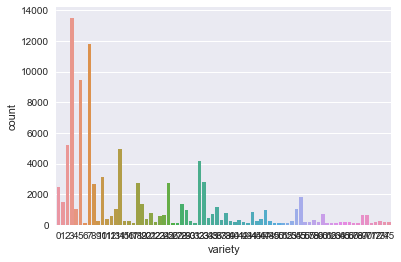

In [230]:
sns.countplot(x='variety', data=wine_data)
plt.show()

In [231]:
variety_counts = wine_data['variety'].value_counts().rename('variety_counts')

wine_data = wine_data.merge(variety_counts.to_frame(),
                                left_on='variety', right_index=True)

popular_varieties = wine_data[wine_data['variety_counts'] > 8000]
wine_data = wine_data.drop(['variety_counts'], axis=1)

popular_varieties = set(popular_varieties['variety'])

In [232]:
# Balance the samples by over/under sampling
columns_list = list(wine_data.columns.values)
test_df = pd.DataFrame(columns=columns_list)

for x in popular_varieties:
    temp_df = pd.DataFrame(columns=columns_list)
    temp_df = wine_data[wine_data['variety'] == x]
    temp_df = resample(temp_df, n_samples=7000)
    test_df = test_df.append(temp_df, ignore_index=True)
print(test_df)

                                        description_text variety  \
0      This is a direct but tasty and well-balanced P...       3   
1      A white wine made from a red grape, this barel...       3   
2      Someone explain this labeling: La Creole Viney...       3   
3      A heavy and dark version of the variety, this ...       3   
4      The dryness and length of this Pinot Noir make...       3   
5      This particular block was first planted in 200...       3   
6      Vigneto annually honors a single grower from a...       3   
7      This is a spicy, fully plush and complete wine...       3   
8      Sourced from a high-altitude vineyard near the...       3   
9      A small, acre-sized parcel gives a wine that h...       3   
10     This is dark, amorphous and shows almost nothi...       3   
11     There is lots of charm in this soft, gentle Pi...       3   
12     Fresh and clean aromas of raspberry and a wild...       3   
13     The fermentation of this white Pinot, whi

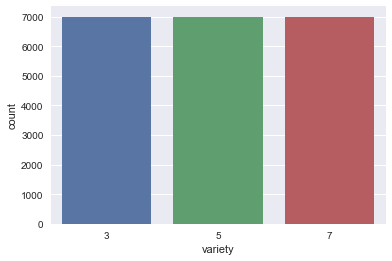

In [233]:
sns.countplot(x='variety', data=test_df)
plt.show()

In [234]:
null_count = test_df.isnull().sum()
null_count[null_count>0]
test_df.reset_index(drop=True, inplace=True)

In [235]:
#Make a list to store our results for a comparison at the end
results = pd.DataFrame(index=range(18))
results['Model'] = ['Logistic Regression',
                    'Logistic Regression',
                    'SVC', 'SVC',
                    'Decision Tree', 'Decision Tree',
                    'Random Forest',
                    'Random Forest',
                    'Ridge', 'Ridge',
                    'KNN', 'KNN', 
                    'Stochastic Gradient Booster', 'Stochastic Gradient Booster',
                    'Gradient Booster',
                    'Gradient Booster',
                    'Neural Network', 'Neural Network'
                    ]
results['Feature Selection'] = ['SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                                'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF',
                               'SpaCY', 'TF_IDF']


Train_Score = []
Test_Score = []
Cross_Validation = []
fold1 = []
fold2 = []
fold3 = []
fold4 = []
fold5 = []

## TF_IDF

In [236]:
#Create a testing function that will fit the test with PCA and our selected features from both RFECV and Random Forest
def testing_func(test, models, method):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in   
    for x in models:
        test.fit(x[0], x[1])
        scores.append(test.score(x[0], x[1]))
        scores.append(test.score(x[2], x[3]))
    
    #Let's store the results from our local list into the main list
    p=1
    for s in scores:
        p+=1
        if p % 2 == 0:
            Train_Score.append(s)
        else:
            Test_Score.append(s)

    # Create a local dataframe to display our results cleanly
    local_results_df=pd.DataFrame(scores, columns=['Accuracy'], index=[method])
    print(local_results_df)
    
    #Create a list and put it through a For loop to do the Cross Validation
    training_model = models[0]
    Cross_Validation0 = cross_val_score(test, training_model[0], training_model[1], cv=5)
    Cross_Validation.append(Cross_Validation0)
        
    #Divide up the results into 5 different folds for display
    fold1.append(Cross_Validation0[0])
    fold2.append(Cross_Validation0[1])
    fold3.append(Cross_Validation0[2])
    fold4.append(Cross_Validation0[3])
    fold5.append(Cross_Validation0[4])
    print('\nCross Validation Score with 5 folds with {} features:\n{}'.format(x[1], Cross_Validation0))
  

In [237]:
X = test_df['description_text']
y = test_df['variety']
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2) )
X = vect2.fit_transform(X)

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train2, y_test2= train_test_split(X, y, test_size=0.4, random_state=0)

#Applying the vectorizer

y_train2 = y_train2.astype(int)
y_test2 = y_test2.astype(int)

In [238]:
tfidf_models = [[X_train_tfidf, y_train2, X_test_tfidf, y_test2]] 
T_method = ['TF_IDF Training', 'TF_IDF Test']

In [239]:
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

In [240]:
start = datetime.now()
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
testing_func(lr, tfidf_models, T_method)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  0.975714
TF_IDF Test      0.953095

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.94287981  0.94563492  0.94444444  0.95079365  0.94362842]
It took the following time to complete this task: 0:00:03.677927


In [241]:
start = datetime.now()
svc = LinearSVC(multi_class='ovr')
testing_func(svc, tfidf_models, T_method)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  0.994683
TF_IDF Test      0.953929

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.94565649  0.94563492  0.94801587  0.94920635  0.94323144]
It took the following time to complete this task: 0:00:00.795235


In [242]:
start = datetime.now()
dtc = DecisionTreeClassifier()
testing_func(dtc, tfidf_models, T_method)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  1.000000
TF_IDF Test      0.902024

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.90003967  0.88293651  0.8984127   0.89722222  0.883684  ]
It took the following time to complete this task: 0:00:10.573829


In [243]:
start = datetime.now()
rfc = RandomForestClassifier()
testing_func(rfc, tfidf_models, T_method)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  0.997302
TF_IDF Test      0.929405

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.93891313  0.925       0.925       0.93134921  0.91822152]
It took the following time to complete this task: 0:00:03.459957


In [244]:
start = datetime.now()
ridge = RidgeClassifier()
testing_func(ridge, tfidf_models, T_method)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  0.982937
TF_IDF Test      0.945714

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.93534312  0.9452381   0.94206349  0.94166667  0.94045256]
It took the following time to complete this task: 0:00:02.864943


In [245]:
start = datetime.now()
gbc = GradientBoostingClassifier()
testing_func(gbc, tfidf_models, T_method)
gbc.fit(X_train_tfidf, y_train2)
gbc_scores = gbc.score(X_test_tfidf, y_test2)
print('It took the following time to complete this task:', datetime.now() - start)

                 Accuracy
TF_IDF Training  0.935556
TF_IDF Test      0.919405

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    5
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     5
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.92304641  0.91825397  0.91507937  0.93134921  0.91147281]
It took the following time to complete this task: 0:03:17.606576


## SpaCy

In [246]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
def bow_features(sentences, common_words):

    # Scaffold the data frame and initialize counts to zero.
    s_index = len(sentences)
    df = pd.DataFrame(columns=common_words, index=range(s_index))
    
    df['description_text'] = sentences['description_text']
    df['variety'] = sentences['variety']
    df = df.fillna(0)
    

    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['description_text']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
       
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1

        # This counter is just to make sure the kernel didn't hang.
        if i % 1000 == 0:
            print("Processing row {}".format(i))
            
    return df


In [247]:
start = datetime.now()
nlp = spacy.load('en')
parsed_wine = test_df
parsed_wine['description_text'] = parsed_wine['description_text'].apply(lambda x: nlp(x))

description_words = parsed_wine['description_text'].apply(bag_of_words)
flat_list = [item for sublist in description_words for item in sublist]
common_words = set(flat_list)
word_counts = bow_features(parsed_wine, common_words)
print(word_counts.head(10))
print('It took the following time to complete this task:', datetime.now() - start)

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 10000
Processing row 11000
Processing row 12000
Processing row 13000
Processing row 14000
Processing row 15000
Processing row 16000
Processing row 17000
Processing row 18000
Processing row 19000
Processing row 20000
   44  douse  moreau  management  virtually  outcrop  objective  machard  \
0   0      0       0           0          0        0          0        0   
1   0      0       0           0          0        0          0        0   
2   0      0       0           0          0        0          0        0   
3   0      0       0           0          0        0          0        0   
4   0      0       0           0          0        0          0        0   
5   0      0       0           0          0        0          0        0   
6   0      0       0           0        

In [248]:
X = word_counts.drop(['variety', 'description_text'], 1)
y = word_counts['variety']

#splitting into training and test sets
X_train_Spacy, X_test_Spacy, y_train_Spacy, y_test_Spacy= train_test_split(X, y, test_size=0.4, random_state=0)


In [249]:
Spacy_models = [[X_train_Spacy, y_train_Spacy, X_test_Spacy, y_test_Spacy]]
S_method = ['Spacy Training', 'Spacy Test']

In [250]:
start = datetime.now()
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
testing_func(lr, Spacy_models, S_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
Spacy Training  0.996111
Spacy Test      0.945238

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    6
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     6
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.93460166  0.93735131  0.93928571  0.94122319  0.93126738]
It took the following time to complete this task: 0:02:56.465774


In [251]:
start = datetime.now()
svc = LinearSVC(multi_class='ovr')
testing_func(svc, Spacy_models, S_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
Spacy Training  0.999603
Spacy Test      0.934048

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    6
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     6
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.92429647  0.92386994  0.93531746  0.93129468  0.92093762]
It took the following time to complete this task: 0:00:24.594003


In [252]:
start = datetime.now()
dtc = DecisionTreeClassifier()
testing_func(dtc, Spacy_models, S_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
Spacy Training  1.000000
Spacy Test      0.901071

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    6
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     6
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.89298454  0.88858049  0.90515873  0.90230342  0.89431863]
It took the following time to complete this task: 0:01:09.639993


In [253]:
start = datetime.now()
rfc = RandomForestClassifier()
testing_func(rfc, Spacy_models, S_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
Spacy Training  0.998095
Spacy Test      0.920595

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    6
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     6
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.90685692  0.91673275  0.91269841  0.91898332  0.91060787]
It took the following time to complete this task: 0:00:22.727111


In [254]:
start = datetime.now()
ridge = RidgeClassifier()
testing_func(ridge, Spacy_models, S_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
Spacy Training  0.989365
Spacy Test      0.914048

Cross Validation Score with 5 folds with 2717     3
7089     5
2932     3
13930    5
8022     5
11618    5
15999    7
12821    5
11946    5
16402    7
10066    5
265      3
8465     5
491      3
4627     3
5303     3
2083     3
1299     3
10011    5
8325     5
14574    7
16071    7
3350     3
19637    7
16927    7
20095    7
9475     5
12757    6
5178     3
3884     3
        ..
7599     5
1871     3
18430    7
7877     6
4851     3
5072     3
2163     3
6036     3
6921     3
6216     3
16921    7
2897     3
18606    7
10327    5
18983    7
17089    7
14650    7
19852    7
6744     3
15832    7
15430    7
14935    7
14116    7
20757    7
9225     5
13123    5
19648    7
9845     5
10799    5
2732     3
Name: variety, Length: 12600, dtype: int64 features:
[ 0.90725327  0.90126883  0.91071429  0.91024623  0.89749702]
It took the following time to complete this task: 0:03:31.474516


## Improve the accuracy of one of the models

In [255]:
# Run the same optimization tool for gradient boosting
start = datetime.now()
clf = GradientBoostingClassifier()
parameters = {'n_estimators':[50, 100, 200], 'learning_rate': [0.25, 0.5],
              'max_depth':[8,10]}
grid = GridSearchCV(clf, parameters).fit(X_train_tfidf, y_train2)
predicted = grid.predict(X_test_tfidf)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_
print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 200} with a score of %0.9456349206349206
It took the following time to complete this task: 0:38:38.842129


In [256]:
start = datetime.now()
gbc = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], learning_rate=parameters['learning_rate'],
                                 max_depth=parameters['max_depth'])
print('The old score was: {}'.format(gbc_scores))
gbc.fit(X_train_tfidf, y_train2)
print('The new score after tuning is: {}'.format(gbc.score(X_test_tfidf, y_test2)))

print('It took the following time to complete this task:', datetime.now() - start)

The old score was: 0.9195238095238095
The new score after tuning is: 0.9557142857142857
It took the following time to complete this task: 0:02:50.029652
